# Transform ASIF data by constructing financial variables raw data data to S3

# Objective(s)

## Business needs 

Transform (creating financial variables) ASIF data using Athena and save output to S3 + Glue. 

## Description

### Objective 

Construct the financial ratio variables by aggregating the data (not anymore at the firm level)

The asif_financial_ratio  has the following levels:

* year
* city
* industry -> 2 digits compared with 4 digits with the parent task

**Construction variables**

Rescale output, fa_net, employment
construct the following ratio:
* If possible compute by:
  * industry level
  * city-industry level
  * city-industry-year level
1. Working capital: cuasset- 流动负债合计 (c95)
2. Working capital requirement: 存货 (c81) + 应收帐款 (c80) - 应付帐款 (c96)
3. Current Ratio: cuasset/流动负债合计 (c95)
4. Cash ratio: (( 其中：短期投资 (c79) + 应收帐款 (c80) + 存货 (c81)) - cuasset)/ 流动负债合计 (c95)
5. Debt to total asset:
  1. (流动负债合计 (c95) + 长期负债合计 (c97)) / 资产总计318 (c93)
  2. 负债合计 (c98)/ 资产总计318 (c93)
6. Return on Asset: 全年营业收入合计 (c64) - (主营业务成本 (c108) + 营业费用 (c113) + 管理费用 (c114) + 财产保险费 (c116) + 劳动、失业保险费 (c118)+ 财务费用 (c124) + 本年应付工资总额 (wage)) /资产总计318 (c93)
7. Asset turnover ratio: 全年营业收入合计 (c64) /(ΔΔ 资产总计318 (c93)/2)
8. R&D intensity: rdfee/全年营业收入合计 (c64)
9. Inventory to sales: 存货 (c81) / 全年营业收入合计 (c64)
10. Asset Tangibility: 固定资产合计 (c85) - 无形资产 (c91)
11. Account payable to total asset: (Δ 应付帐款 (c96))/ (Δ资产总计318 (c93))

**Steps** 

We will clean the table by doing the following steps:

1. Compute the financial ratio by aggregating the data

**Cautious**

* Make sure there is no duplicates when merging ratio from different level

**Target**

* The file is saved in S3: 
  * bucket: datalake-datascience 
  * path: DATA/ECON/FIRM_SURVEY/ASIF_CHINA/TRANSFORMED/FINANCIAL_RATIO 
* Glue data catalog should be updated
  * database: firms_survey 
  * table prefix: asif_city_industry 
    * table name (prefix + last folder S3 path): asif_city_industry_financial_ratio 

# Metadata

* Key: spr04tlko02392a
* Parent key (for update parent):  
* Notebook US Parent (i.e the one to update): 
* https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/00_asif_financial_ratio.md
* Epic: Epic 2
* US: US 1
* Date Begin: 11/23/2020
* Duration Task: 1
* Description: Transform (creating financial variables) ASIF data using Athena and save output to S3 + Glue. 
* Step type: Transform table
* Status: Active
* Source URL: Create Task and Epics
* Task type: Jupyter Notebook
* Users: Thomas Pernet
* Watchers: Thomas Pernet
* User Account: https://468786073381.signin.aws.amazon.com/console
* Estimated Log points: 10
* Task tag: #athena,#glue,#crawler,#financial-ratio
* Toggl Tag: #data-transformation
* current nb commits: 
 * Meetings:  
* Presentation:  
* Email Information:  
  * thread: Number of threads: 0(Default 0, to avoid display email)
  *  

# Input Cloud Storage [AWS/GCP]

## Table/file

* Origin: 
* Athena
* Name: 
* asif_firms_prepared
* Github: 
  * https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/01_prepare_tables/00_prepare_asif.md

# Destination Output/Delivery

## Table/file

* Origin: 
* S3
* Athena
* Name:
* DATA/ECON/FIRM_SURVEY/ASIF_CHINA/TRANSFORMED/FINANCIAL_RATIO
* asif_city_industry_financial_ratio
* GitHub:
* https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/00_asif_financial_ratio.md
* URL: 
  * datalake-datascience/DATA/ECON/FIRM_SURVEY/ASIF_CHINA/TRANSFORMED/FINANCIAL_RATIO
* 

# Knowledge

## List of candidates

* [List of financial ratios that can be computed with ASIF panel data](https://roamresearch.com/#/app/thomas_db/page/PS3o9Z3VA)

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import os, shutil, json

path = os.getcwd()
parent_path = str(Path(path).parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-3'
bucket = 'datalake-datascience'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = True) 
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

# Prepare query 

Write query and save the CSV back in the S3 bucket `datalake-datascience` 

# Steps

Detail computation:

| index | Metrics                        | comments                                           | variables                                                                                                                                                                                      | Roam_link                                       |
|-------|--------------------------------|----------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------|
| 1     | Working capital                | Current asset - current liabilities                | cuasset- 流动负债合计 (c95)                                                                                                                                                                    | #working-capital-requirement                    |
| 2     | working capital requirement    | Inventory + Accounts receivable - Accounts payable | 存货 (c81) + 应收帐款 (c80) - 应付帐款  (c96)                                                                                                                                                  | #working-capital                                |
| 3     | current ratio                  | Current asset /current liabilities                 | cuasset/流动负债合计 (c95)                                                                                                                                                                     | #current-ratio                                  |
| 4     | cash ratio                     | (Cash + marketable securities)/current liabilities | (( 其中：短期投资 (c79) + 应收帐款 (c80) + 存货 (c81)) - cuasset)/ 流动负债合计 (c95)                                                                                                          | #cash-asset #cash-ratio                         |
| 5     | Total Debt to Total Assets     | (Short-Tern Debt + Long-Term Debt)/total asset     | (流动负债合计 (c95) + 长期负债合计 (c97)) / 资产总计318 (c93)                                                                                                                                  | #total-debt-to-total-assets                     |
| 6     |                                | Total debt/total asset                             | 负债合计 (c98)/  资产总计318 (c93)                                                                                                                                                             |                                                 |
| 7     | Return on Asset                | Net income / Total assets                          | 全年营业收入合计 (c64) - (主营业务成本 (c108) + 营业费用 (c113) + 管理费用 (c114) + 财产保险费 (c116) + 劳动、失业保险费 (c118)+ 财务费用 (c124) + 本年应付工资总额 (wage)) /资产总计318 (c93) | #return-on-asset                                |
| 8     | Asset Turnover Ratio           | Total sales / ((delta total asset)/2)              | 全年营业收入合计 (c64) /($\Delta$ 资产总计318 (c93)/2)                                                                                                                                         | #asset-turnover-ratio                           |
| 9     | External finance dependence    |                                                    |                                                                                                                                                                                                | #external-finance-dependence                    |
| 10    | R&D intensity                  | RD / Sales                                         | rdfee/全年营业收入合计 (c64)                                                                                                                                                                                    | #rd-intensity                                   |
| 11    | Inventory to sales             | Inventory / sales                                  | 存货 (c81) / 全年营业收入合计 (c64)                                                                                                                                                                             | #inventory-to-sales                             |
| 12    | Asset tangibility              | Total fixed assets - Intangible assets             | 固定资产合计 (c85) - 无形资产 (c91)                                                                                                                                                            | #asset-tangibility                              |
| 13    | Account payable to total asset | (delta account payable)/ (delta total asset)       | ($\Delta$ 应付帐款  (c96))/ ($\Delta$ 资产总计318 (c93))                                                                                                                                       | #change-account-paybable-to-change-total-assets |
    
    
**pct missing**

![](https://drive.google.com/uc?export=view&id=1LPNhZIPkJgx0-ZsM6NLNAB6dGH9h7ELo)

## Example step by step



In [4]:
DatabaseName = 'firms_survey'
s3_output_example = 'SQL_OUTPUT_ATHENA'

1. Count the number of digit by industry

We want to keep only the fist two digit

In [5]:
query = """
SELECT len, COUNT(len) as CNT
FROM (
SELECT length(cic) AS len
FROM asif_firms_prepared 
)
GROUP BY len
ORDER BY CNT
"""
output = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'example_1'
                )
output

,len,CNT
0,3,65837
1,4,2119627


Count when substring 1 or 2 digits

In [6]:
query = """
WITH test AS (
SELECT
CASE 
WHEN LENGTH(cic) = 4 THEN substr(cic,1, 2) 
ELSE substr(cic,1, 1) END AS indu_2
FROM asif_firms_prepared 
)

SELECT len, COUNT(len) as CNT
FROM (
SELECT length(indu_2) AS len
FROM test 
)
GROUP BY len
ORDER BY CNT
"""
output = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'example_1'
                )
output

,len,CNT
0,1,65837
1,2,2119627


1. Add consistent city code

There is a need to remove the duplicates in `china_city_code_normalised` because it is possible to have the same code but different Chinese name link Chongqing

In [7]:
query = """
SELECT *
FROM chinese_lookup.china_city_code_normalised 
WHERE extra_code = '5001'
"""
output = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'example_1'
                )
output

,extra_code,geocode4_corr,citycn,cityen,citycn_correct,cityen_correct,province_cn,province_en
0,5001,5001,重庆市,Chongqing,重庆,Chongqing,重庆市,Chongqing
1,5001,5001,重庆,Chongqing,重庆,Chongqing,重庆市,Chongqing


In [8]:
query = """
WITH test AS (
SELECT firm, year, citycode, geocode4_corr, CASE 
WHEN LENGTH(cic) = 4 THEN substr(cic,1, 2) 
ELSE substr(cic,1, 1) END AS indu_2
  FROM firms_survey.asif_firms_prepared 
INNER JOIN 
  (
  SELECT extra_code, geocode4_corr
  FROM chinese_lookup.china_city_code_normalised 
  GROUP BY extra_code, geocode4_corr
  ) as no_dup_citycode
ON asif_firms_prepared.citycode = no_dup_citycode.extra_code
  )
  SELECT CNT, COUNT(*) AS CNT_dup
  FROM(
  SELECT firm, year, geocode4_corr, indu_2, COUNT(*) AS CNT
  FROM test
  GROUP BY firm, year, geocode4_corr, indu_2
    )
    GROUP BY CNT
"""
output = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'example_1'
                )
output

,CNT,CNT_dup
0,1,2088300


Make sure the output is the same before and after the use of city consistent code

In [9]:
query = """
WITH test AS (
SELECT 
  year, 
  geocode4_corr,
  cic, 
  SUM(output) as sum_output,
  SUM(c81) + SUM(c80) - SUM(c96) AS working_capital_cit, 
  SUM(c85) - SUM(c91) AS asset_tangibility_cit, 
  CAST(
    SUM(cuasset) AS DECIMAL(16, 5)
  ) / NULLIF(
    CAST(
      SUM(c95) AS DECIMAL(16, 5)
    ), 
    0
  ) AS current_ratio_cit, 
  CAST(
    (SUM(c79) + SUM(c80) + SUM(c81)) - SUM(cuasset) AS DECIMAL(16, 5)
  ) / NULLIF(CAST(
    SUM(c93) AS DECIMAL(16, 5)
  ), 
    0
  ) AS cash_assets_cit, 
  CAST(
    SUM(c95) + SUM(c97) AS DECIMAL(16, 5)
  )/ NULLIF(
    CAST(
      SUM(c93) AS DECIMAL(16, 5)
    ), 
    0
  ) AS liabilities_assets_cit, 
  CAST(
    SUM(c64) - SUM(c134) AS DECIMAL(16, 5)
  )/ NULLIF(
    CAST(
      SUM(c98) AS DECIMAL(16, 5)
    ), 
    0
  ) AS return_on_asset_cit, 
  CAST(
    SUM(cuasset) AS DECIMAL(16, 5)
  )/ NULLIF(
    CAST(
      (
        SUM(c98) - lag(
          SUM(c98), 
          1
        ) over(
          partition by geocode4_corr, 
          cic 
          order by 
            geocode4_corr, 
            cic, 
            year
        )
      )/ 2 AS DECIMAL(16, 5)
    ), 
    0
  ) AS sales_assets_cit 
FROM firms_survey.asif_firms_prepared 
INNER JOIN 
  (
  SELECT extra_code, geocode4_corr
  FROM chinese_lookup.china_city_code_normalised 
  GROUP BY extra_code, geocode4_corr
  ) as no_dup_citycode
  
ON asif_firms_prepared.citycode = no_dup_citycode.extra_code
GROUP BY 
  geocode4_corr, 
  cic, 
  year 
)
SELECT SUM(sum_output) as sum_output
FROM test

"""
output_1 = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'example_1'
                )
output_1

,sum_output
0,166657829347


In [10]:
query = """
SELECT SUM(output) as sum_output
FROM firms_survey.asif_firms_prepared 

"""
output_2 = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'example_1'
                )
output_2

,sum_output
0,170680191587


In [11]:
output_1 > output_2

,sum_output
0,False


3. Computation ratio by industry

As an average over year 2002 to 2006. As in Fan, compute directly at the industry, then get the average

- Computed using the Chinese data
    - The ExtFin based on Chinese data is calculated at the 2-digit Chinese Industrial Classification (CIC) level
    - Data available in year 2004–2006 in the NBSC Database. We calculate the aggregate rather than the median external finance dependence at 2-digit industry level, because the median firm in Chinese database often has no capital expenditure
    - In our sample, approximately 68.1% firms have zero capital expenditure


In [14]:
pd.set_option('display.max_rows', None)

In [15]:
query = """
WITH test AS (
SELECT *, CASE 
WHEN LENGTH(cic) = 4 THEN substr(cic,1, 2)
ELSE substr(cic,1, 1) END AS indu_2,
c98 + c99 as total_asset
FROM firms_survey.asif_firms_prepared 
)
SELECT * 
FROM (
WITH ratio AS (
SELECT 
  year, 
  indu_2, 
  SUM(cuasset)  as curr_asset,
  SUM(c95) as curr_liabilities,
  SUM(cuasset) - SUM(c95) as workink_capital_it,
  SUM(c81) + SUM(c80) - SUM(c96) AS working_capital_requirement_it,   
  CAST(
    SUM(cuasset) AS DECIMAL(16, 5)
  ) / NULLIF(
    CAST(
      SUM(c95) AS DECIMAL(16, 5)
    ), 
    0
  ) AS current_ratio_it, 
  CAST(
    (SUM(c79) + SUM(c80) + SUM(c81)) - SUM(cuasset) AS DECIMAL(16, 5)
  ) / NULLIF(CAST(
    SUM(c95) AS DECIMAL(16, 5)
  ), 
    0
  ) AS cash_assets_it,
  
  CAST(
    SUM(c95) + SUM(c97) AS DECIMAL(16, 5)
  )/ NULLIF(
    CAST(
      SUM(total_asset) AS DECIMAL(16, 5)
    ), 
    0
  ) AS liabilities_assets_m1_it, 
  
  SUM(c98)/ NULLIF(
    CAST(
      SUM(total_asset) AS DECIMAL(16, 5) 
    ), 
    0
  ) as liabilities_assets_m2_it,
  
  CAST(SUM(sales) - (SUM(c108) + SUM(c113) + SUM(c114) + SUM(c116) + SUM(c118) + SUM(c124) + SUM(wage)) AS DECIMAL(16, 5))/ NULLIF(
  CAST(SUM(total_asset) AS DECIMAL(16, 5)), 0) AS return_on_asset_it,
  CAST(
    SUM(sales) AS DECIMAL(16, 5)
  )/ NULLIF(
    CAST(
      (
        SUM(total_asset) - lag(
          SUM(total_asset), 
          1
        ) over(
          partition by indu_2 
          order by 
            indu_2, 
            year
        )
      )/ 2 AS DECIMAL(16, 5)
    ), 
    0
  ) AS sales_assets_it,
  
  CAST(SUM(rdfee) AS DECIMAL(16, 5))/ NULLIF(CAST(SUM(sales) AS DECIMAL(16, 5)),0) as rd_intensity_it,
  CAST(SUM(c81)  AS DECIMAL(16, 5))/ NULLIF(CAST(SUM(sales) AS DECIMAL(16, 5)),0) as inventory_to_sales_it,
  SUM(tofixed) - SUM(c92) AS asset_tangibility_it,
  
  CAST(
      (
        SUM(c96) - lag(
          SUM(c96), 
          1
        ) over(
          partition by indu_2 
          order by 
            indu_2, 
            year
        )
      ) AS DECIMAL(16, 5)
      )/
      NULLIF(
    CAST(
      (
        SUM(total_asset) - lag(
          SUM(total_asset), 
          1
        ) over(
          partition by indu_2 
          order by 
            indu_2, 
            year
        )
      )/ 2 AS DECIMAL(16, 5)
    ),0) as account_paybable_to_asset_it
  
FROM test
WHERE year in ('2001', '2002', '2003', '2004', '2005', '2006') 
GROUP BY 
  indu_2, 
  year 
  )
  SELECT
  year,
  indu_2,
  curr_asset,
  curr_liabilities,
  workink_capital_it AS workink_capital_i,
  working_capital_requirement_it AS working_capital_requirement_i,
  current_ratio_it AS current_ratio_i,
  cash_assets_it AS cash_assets_i,
  liabilities_assets_m1_it AS liabilities_assets_m1_i,
  liabilities_assets_m2_it AS liabilities_assets_m2_i,
  return_on_asset_it AS return_on_asset_i,
  sales_assets_it AS sales_assets_i,
  rd_intensity_it AS rd_intensity_i,
  inventory_to_sales_it AS inventory_to_sales_i,
  asset_tangibility_it AS asset_tangibility_i,
  account_paybable_to_asset_it AS account_paybable_to_asset_i
  FROM ratio
  ORDER BY year, workink_capital_i
  )
"""
output = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'example_3'
                )
(
    output
    #.style
    #.format('{0:,.2f}')
)

,year,indu_2,curr_asset,curr_liabilities,workink_capital_i,working_capital_requirement_i,current_ratio_i,cash_assets_i,liabilities_assets_m1_i,liabilities_assets_m2_i,return_on_asset_i,sales_assets_i,rd_intensity_i,inventory_to_sales_i,asset_tangibility_i,account_paybable_to_asset_i
0,2001,17,294853615,330059650,-35206035,NaN,0.89333,NaN,0.66875,0.67494,-0.04443,NaN,NaN,0.22283,344559950,NaN
1,2001,31,252577994,282494603,-29916609,NaN,0.89410,NaN,0.62115,0.63113,-0.03226,NaN,NaN,0.20960,375849644,NaN
2,2001,13,147592984,175561395,-27968411,NaN,0.84069,NaN,0.66919,0.68127,-0.01220,NaN,NaN,0.13726,158413897,NaN
3,2001,25,110298081,123373095,-13075014,NaN,0.89402,NaN,0.52891,0.56539,-0.00443,NaN,NaN,0.10335,277371175,NaN
4,2001,32,340133111,352204150,-12071039,NaN,0.96573,NaN,0.50819,0.50944,-0.01907,NaN,NaN,0.20465,674860045,NaN
5,2001,22,107333280,117586756,-10253476,NaN,0.91280,NaN,0.63589,0.63975,-0.07950,NaN,NaN,0.19062,152174354,NaN
6,2001,26,347149997,354829303,-7679306,NaN,0.97836,NaN,0.60130,0.60799,-0.02252,NaN,NaN,0.16518,540272813,NaN
7,2001,14,80450593,87293361,-6842768,NaN,0.92161,NaN,0.59014,0.59990,-0.01295,NaN,NaN,0.15145,93008023,NaN
8,2001,28,49590873,55980985,-6390112,NaN,0.88585,NaN,0.59789,0.60295,-0.01884,NaN,NaN,0.15818,109336603,NaN
9,2001,33,115714257,121318006,-5603749,NaN,0.95381,NaN,0.63935,0.64233,-0.02692,NaN,NaN,0.21946,163438836,NaN


The table shows that years prior to 2004 have large missing values, as emphasided by Fan et al. So we will filter the year after 2004 included. 

In [38]:
query = """
WITH test AS (
  SELECT 
    *, 
    CASE WHEN LENGTH(cic) = 4 THEN substr(cic,1, 2) ELSE concat('0',substr(cic,1, 1)) END AS indu_2, 
    c98 + c99 as total_asset 
  FROM 
    firms_survey.asif_firms_prepared
) 
SELECT 
  * 
FROM 
  (
    WITH ratio AS (
      SELECT 
        year, 
        indu_2, 
        SUM(cuasset) - SUM(c95) as workink_capital_it, 
        SUM(c81) + SUM(c80) - SUM(c96) AS working_capital_requirement_it, 
        CAST(
          SUM(cuasset) AS DECIMAL(16, 5)
        ) / NULLIF(
          CAST(
            SUM(c95) AS DECIMAL(16, 5)
          ), 
          0
        ) AS current_ratio_it, 
        CAST(
          (
            SUM(c79) + SUM(c80) + SUM(c81)
          ) - SUM(cuasset) AS DECIMAL(16, 5)
        ) / NULLIF(
          CAST(
            SUM(c95) AS DECIMAL(16, 5)
          ), 
          0
        ) AS cash_assets_it, 
        CAST(
          SUM(c95) + SUM(c97) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            SUM(total_asset) AS DECIMAL(16, 5)
          ), 
          0
        ) AS liabilities_assets_m1_it, 
        SUM(c98)/ NULLIF(
          CAST(
            SUM(total_asset) AS DECIMAL(16, 5)
          ), 
          0
        ) as liabilities_assets_m2_it, 
        CAST(
          SUM(sales) - (
            SUM(c108) + SUM(c113) + SUM(c114) + SUM(c116) + SUM(c118) + SUM(c124) + SUM(wage)
          ) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            SUM(total_asset) AS DECIMAL(16, 5)
          ), 
          0
        ) AS return_on_asset_it, 
        CAST(
          SUM(sales) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            (
              SUM(total_asset) - lag(
                SUM(total_asset), 
                1
              ) over(
                partition by indu_2 
                order by 
                  indu_2, 
                  year
              )
            )/ 2 AS DECIMAL(16, 5)
          ), 
          0
        ) AS sales_assets_it, 
        CAST(
          SUM(rdfee) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            SUM(sales) AS DECIMAL(16, 5)
          ), 
          0
        ) as rd_intensity_it, 
        CAST(
          SUM(c81) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            SUM(sales) AS DECIMAL(16, 5)
          ), 
          0
        ) as inventory_to_sales_it, 
        SUM(tofixed) - SUM(c92) AS asset_tangibility_it, 
        CAST(
          (
            SUM(c96) - lag(
              SUM(c96), 
              1
            ) over(
              partition by indu_2 
              order by 
                indu_2, 
                year
            )
          ) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            (
              SUM(total_asset) - lag(
                SUM(total_asset), 
                1
              ) over(
                partition by indu_2 
                order by 
                  indu_2, 
                  year
              )
            )/ 2 AS DECIMAL(16, 5)
          ), 
          0
        ) as account_paybable_to_asset_it 
      FROM 
        test 
      WHERE 
        year in ('2004', '2005', '2006') 
      GROUP BY 
        indu_2, 
        year
    ) 
    SELECT 
      * 
    FROM 
      (
        WITH agg AS (
          SELECT 
            indu_2, 
            'FAKE_GROUP' as fake, 
            AVG(workink_capital_it) AS workink_capital_i, 
            AVG(working_capital_requirement_it) AS working_capital_requirement_i, 
            AVG(current_ratio_it) AS current_ratio_i, 
            AVG(cash_assets_it) AS cash_assets_i, 
            AVG(liabilities_assets_m1_it) AS liabilities_assets_m1_i, 
            AVG(liabilities_assets_m2_it) AS liabilities_assets_m2_i, 
            AVG(return_on_asset_it) AS return_on_asset_i, 
            AVG(sales_assets_it) AS sales_assets_i, 
            AVG(rd_intensity_it) AS rd_intensity_i, 
            AVG(inventory_to_sales_it) AS inventory_to_sales_i, 
            AVG(asset_tangibility_it) AS asset_tangibility_i, 
            AVG(account_paybable_to_asset_it) AS account_paybable_to_asset_i 
          FROM 
            ratio 
          GROUP BY 
            indu_2 
          -- ORDER BY 
          -- workink_capital_i
        ) 
        SELECT 
          field0 AS indu_2, 
          val_1[ 'workink_capital' ] AS workink_capital_i, 
          val_2[ 'workink_capital' ] AS std_workink_capital_i, 
          val_1[ 'working_capital_requirement' ] AS working_capital_requirement_i, 
          val_2[ 'working_capital_requirement' ] AS std_working_capital_requirement_i, 
          val_1[ 'current_ratio' ] AS current_ratio_i, 
          val_2[ 'current_ratio' ] AS std_current_ratio_i, 
          val_1[ 'cash_assets' ] AS cash_assets_i, 
          val_2[ 'cash_assets' ] AS std_cash_assets_i, 
          val_1[ 'liabilities_assets_m1' ] AS liabilities_assets_m1_i, 
          val_2[ 'liabilities_assets_m1' ] AS std_liabilities_assets_m1_i, 
          val_1[ 'liabilities_assets_m2' ] AS liabilities_assets_m2_i, 
          val_2[ 'liabilities_assets_m2' ] AS std_liabilities_assets_m2_i, 
          val_1[ 'return_on_asset' ] AS return_on_asset_i, 
          val_2[ 'return_on_asset' ] AS std_return_on_asset_i, 
          val_1[ 'sales_assets' ] AS sales_assets_i, 
          val_2[ 'sales_assets' ] AS std_sales_assets_i, 
          val_1[ 'rd_intensity' ] AS rd_intensity_i, 
          val_2[ 'rd_intensity' ] AS std_rd_intensity_i, 
          val_1[ 'inventory_to_sales' ] AS inventory_to_sales_i, 
          val_2[ 'inventory_to_sales' ] AS std_inventory_to_sales_i, 
          val_1[ 'asset_tangibility' ] AS asset_tangibility_i, 
          val_2[ 'asset_tangibility' ] AS std_asset_tangibility_i, 
          val_1[ 'account_paybable_to_asset' ] AS account_paybable_to_asset_i, 
          val_2[ 'account_paybable_to_asset' ] AS std_account_paybable_to_asset_i 
        FROM 
          (
            SELECT 
              field0, 
              map_agg(w, field1) AS val_1, 
              map_agg(w, field2) AS val_2 
            FROM 
              (
                SELECT 
                  w, 
                  names.field0, 
                  names.field1, 
                  names.field2 
                FROM 
                  (
                    SELECT 
                      w, 
                      zip(
                        array_indu_2, 
                        array_w, 
                        transform(
                          array_w, 
                          x -> (x - avg)/ std_w
                        )
                      ) as zip_values 
                    FROM 
                      (
                        SELECT 
                          w, 
                          avg, 
                          array_w, 
                          array_indu_2, 
                          std_w 
                        FROM 
                          (
                            SELECT 
                              'workink_capital' as w, 
                              AVG(workink_capital_i) as avg, 
                              ARRAY_AGG(workink_capital_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(workink_capital_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'working_capital_requirement' as w, 
                              AVG(working_capital_requirement_i) as avg, 
                              ARRAY_AGG(working_capital_requirement_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(working_capital_requirement_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'current_ratio' as w, 
                              AVG(current_ratio_i) as avg, 
                              ARRAY_AGG(current_ratio_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(current_ratio_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'cash_assets' as w, 
                              AVG(cash_assets_i) as avg, 
                              ARRAY_AGG(cash_assets_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(cash_assets_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'liabilities_assets_m1' as w, 
                              AVG(liabilities_assets_m1_i) as avg, 
                              ARRAY_AGG(liabilities_assets_m1_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(liabilities_assets_m1_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'liabilities_assets_m2' as w, 
                              AVG(liabilities_assets_m2_i) as avg, 
                              ARRAY_AGG(working_capital_requirement_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(liabilities_assets_m2_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'return_on_asset' as w, 
                              AVG(return_on_asset_i) as avg, 
                              ARRAY_AGG(return_on_asset_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(return_on_asset_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'sales_assets' as w, 
                              AVG(sales_assets_i) as avg, 
                              ARRAY_AGG(sales_assets_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(sales_assets_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'rd_intensity' as w, 
                              AVG(rd_intensity_i) as avg, 
                              ARRAY_AGG(rd_intensity_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(rd_intensity_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'inventory_to_sales' as w, 
                              AVG(inventory_to_sales_i) as avg, 
                              ARRAY_AGG(inventory_to_sales_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(inventory_to_sales_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'asset_tangibility' as w, 
                              AVG(asset_tangibility_i) as avg, 
                              ARRAY_AGG(asset_tangibility_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(asset_tangibility_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'account_paybable_to_asset' as w, 
                              AVG(account_paybable_to_asset_i) as avg, 
                              ARRAY_AGG(account_paybable_to_asset_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(account_paybable_to_asset_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          )
                      )
                  ) CROSS 
                  JOIN UNNEST(zip_values) as t(names)
              ) 
            GROUP BY 
              field0
          )
      )
      ORDER BY workink_capital_i
  )
"""
output = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'example_3'
                )
(
    output
    #.style
    #.format('{0:,.2f}')
)

,indu_2,workink_capital_i,std_workink_capital_i,working_capital_requirement_i,std_working_capital_requirement_i,current_ratio_i,std_current_ratio_i,cash_assets_i,std_cash_assets_i,liabilities_assets_m1_i,std_liabilities_assets_m1_i,liabilities_assets_m2_i,std_liabilities_assets_m2_i,return_on_asset_i,std_return_on_asset_i,sales_assets_i,std_sales_assets_i,rd_intensity_i,std_rd_intensity_i,inventory_to_sales_i,std_inventory_to_sales_i,asset_tangibility_i,std_asset_tangibility_i,account_paybable_to_asset_i,std_account_paybable_to_asset_i
0,44,-2.611023e+08,-4.357469,-2.698477e+07,-1.350124,0.73583,-1.694019,-0.52858,-0.169856,0.55424,-0.015475,-2.698477e+07,-3.983476e+08,0.00545,-0.222720,9.29790,-0.526674,0.00134,-0.566108,0.02462,-1.813456,3.373574e+09,5.375218,0.15177,0.135368
1,32,-1.061579e+08,-1.848661,1.770230e+08,1.385315,0.88932,-0.911054,-0.46800,0.374007,0.60599,0.747225,1.770230e+08,2.613203e+09,0.03054,0.022262,12.87115,-0.310112,0.00318,0.123719,0.13971,0.184540,1.120057e+09,1.372873,0.21884,0.158313
2,31,-3.045389e+07,-0.622886,1.328797e+08,0.793419,0.93595,-0.673190,-0.41880,0.815706,0.58235,0.398815,1.328797e+08,1.961561e+09,-0.00119,-0.287554,16.14786,-0.111522,0.00156,-0.483629,0.14006,0.190616,5.969052e+08,0.443734,0.19668,0.150732
3,6,-2.300045e+07,-0.502203,2.973566e+07,-0.589588,0.93898,-0.657734,-0.66142,-1.362443,0.60191,0.687093,2.973566e+07,4.389560e+08,-0.02251,-0.495726,6.82344,-0.676643,0.00443,0.592352,0.08485,-0.767846,5.187041e+08,0.304845,0.18879,0.148033
4,17,-1.920944e+07,-0.440820,1.810265e+08,1.438996,0.96298,-0.535308,-0.42942,0.720364,0.60944,0.798072,1.810265e+08,2.672302e+09,-0.02491,-0.519159,22.71447,0.286457,0.00137,-0.554861,0.14519,0.279674,5.218192e+08,0.310378,0.13805,0.130674
5,22,-1.598486e+07,-0.388609,6.302086e+07,-0.143283,0.92159,-0.746442,-0.38694,1.101733,0.60787,0.774933,6.302086e+07,9.303101e+08,0.00746,-0.203094,15.37827,-0.158164,0.00167,-0.442389,0.13381,0.082114,2.712067e+08,-0.134721,0.20310,0.152928
6,28,-1.120548e+07,-0.311222,2.393624e+07,-0.667349,0.90048,-0.854125,-0.51939,-0.087352,0.59239,0.546786,2.393624e+07,3.533452e+08,-0.00242,-0.299564,19.61881,0.098840,0.00185,-0.374906,0.11693,-0.210928,1.562331e+08,-0.338919,0.22045,0.158864
7,7,-5.719694e+06,-0.222398,-7.889138e+06,-1.094080,0.95790,-0.561221,-0.60967,-0.897851,0.33398,-3.261703,-7.889138e+06,-1.164590e+08,0.40419,3.670634,20.08636,0.127177,0.00349,0.239940,0.04516,-1.456875,8.023103e+08,0.808542,0.35433,0.204665
8,45,-3.707072e+06,-0.189811,2.922801e+06,-0.949108,0.91628,-0.773528,-0.68262,-1.552768,0.50262,-0.776259,2.922801e+06,4.314621e+07,-0.03068,-0.575499,10.73793,-0.439399,0.00025,-0.974756,0.06333,-1.141439,8.123579e+07,-0.472118,0.07964,0.110692
9,25,-2.984331e+06,-0.178108,6.382678e+07,-0.132477,0.98682,-0.413698,-0.46310,0.417998,0.54052,-0.217683,6.382678e+07,9.422071e+08,0.02997,0.016697,22.74233,0.288146,0.00080,-0.768558,0.09428,-0.604138,3.855135e+08,0.068293,0.17395,0.142956


In [20]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
cm = sns.light_palette("green", as_cmap=True)
(
    output[['indu_2',
            'workink_capital_i',
            'working_capital_requirement_i',
            'current_ratio_i',
            'cash_assets_i',
            'liabilities_assets_m1_i',
            'liabilities_assets_m2_i',
            'return_on_asset_i',
            'sales_assets_i',
            'rd_intensity_i',
            'inventory_to_sales_i',
            'asset_tangibility_i',
            'account_paybable_to_asset_i']]
    .set_index('indu_2')
    .rank()
    .astype('int64')
    .style
    .background_gradient(cmap=cm)
)

,workink_capital_i,working_capital_requirement_i,current_ratio_i,cash_assets_i,liabilities_assets_m1_i,liabilities_assets_m2_i,return_on_asset_i,sales_assets_i,rd_intensity_i,inventory_to_sales_i,asset_tangibility_i,account_paybable_to_asset_i
indu_2,,,,,,,,,,,,
44,1,1,1,11,17,1,22,6,12,2,39,11
32,2,33,3,22,31,33,29,9,27,21,38,23
31,3,31,7,34,24,31,17,16,15,22,33,17
6,4,15,8,5,29,15,9,3,32,8,31,16
17,5,34,11,32,33,34,7,29,13,29,32,9
22,6,23,6,39,32,23,23,13,17,20,26,19
28,7,12,4,12,26,12,14,25,23,14,18,24
7,8,2,10,7,2,2,38,26,29,3,36,33
45,9,5,5,4,5,5,6,7,2,5,12,6


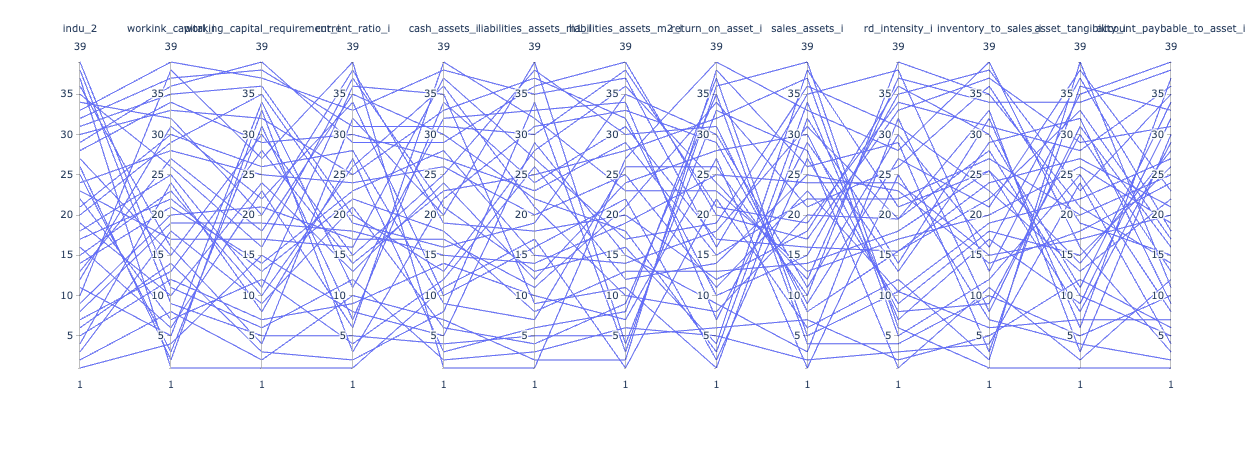

In [25]:
fig = px.parallel_coordinates(
    output[['indu_2',
            'workink_capital_i',
            'working_capital_requirement_i',
            'current_ratio_i',
            'cash_assets_i',
            'liabilities_assets_m1_i',
            'liabilities_assets_m2_i',
            'return_on_asset_i',
            'sales_assets_i',
            'rd_intensity_i',
            'inventory_to_sales_i',
            'asset_tangibility_i',
            'account_paybable_to_asset_i']].rank(),
    labels={
        "workink_capital_i": "workink_capital_i",
        "working_capital_requirement_i": "working_capital_requirement_i",
        "current_ratio_i": "current_ratio_i",
        "cash_assets_i": "cash_assets_i",
        "liabilities_assets_m1_i": "liabilities_assets_m1_i",
        "liabilities_assets_m2_i": "liabilities_assets_m2_i",
        "return_on_asset_i": "return_on_asset_i",
        "sales_assets_i": "sales_assets_i",
        "rd_intensity_i": "rd_intensity_i",
        "inventory_to_sales_i": "inventory_to_sales_i",
        "asset_tangibility_i": "asset_tangibility_i",
        "account_paybable_to_asset_i": "account_paybable_to_asset_i",
    },
    color_continuous_scale=px.colors.diverging.Tealrose,
    color_continuous_midpoint=2,
)
fig

<AxesSubplot:>

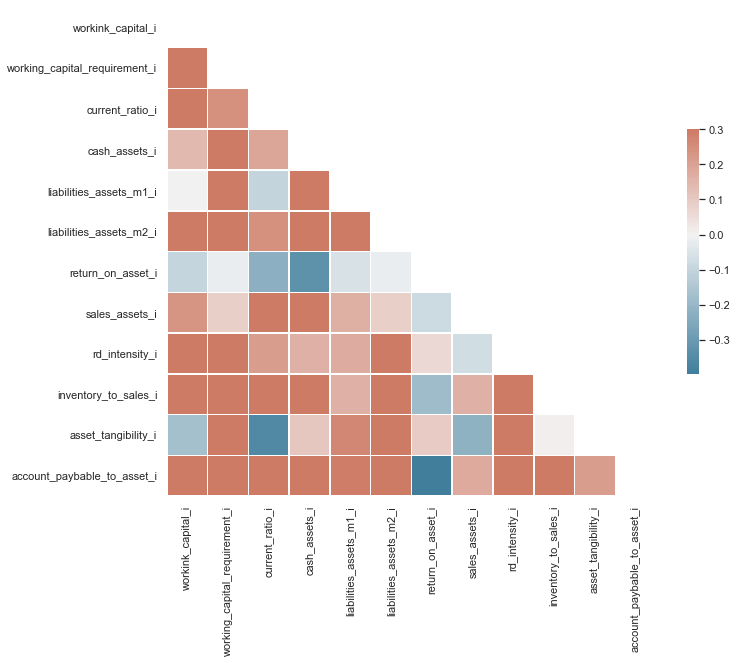

In [26]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = output[['indu_2',
            'workink_capital_i',
            'working_capital_requirement_i',
            'current_ratio_i',
            'cash_assets_i',
            'liabilities_assets_m1_i',
            'liabilities_assets_m2_i',
            'return_on_asset_i',
            'sales_assets_i',
            'rd_intensity_i',
            'inventory_to_sales_i',
            'asset_tangibility_i',
            'account_paybable_to_asset_i']].set_index('indu_2').rank().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Table `asif_city_industry_financial_ratio`


Since the table to create has missing value, please use the following at the top of the query

```
CREATE TABLE database.table_name WITH (format = 'PARQUET') AS
```


Choose a location in S3 to save the CSV. It is recommended to save in it the `datalake-datascience` bucket. Locate an appropriate folder in the bucket, and make sure all output have the same format

First, we need to delete the table (if exist)

In [27]:
table_name = 'asif_city_industry_financial_ratio'
s3_output = 'DATA/ECON/FIRM_SURVEY/ASIF_CHINA/TRANSFORMED/FINANCIAL_RATIO'

In [49]:
try:
    response = glue.delete_table(
        database=DatabaseName,
        table=table_name
    )
    print(response)
except Exception as e:
    print(e)

{'ResponseMetadata': {'RequestId': 'f5f9a984-3465-41ef-9039-ac39947cf019', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 15 Dec 2020 07:13:49 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': 'f5f9a984-3465-41ef-9039-ac39947cf019'}, 'RetryAttempts': 0}}


Clean up the folder with the previous csv file. Be careful, it will erase all files inside the folder

In [50]:
s3.remove_all_bucket(path_remove = s3_output)

True

In [51]:
%%time
query = """
CREATE TABLE {0}.{1} WITH (format = 'PARQUET') AS

WITH test AS (
  SELECT 
    *, 
    CASE WHEN LENGTH(cic) = 4 THEN substr(cic,1, 2) ELSE concat('0',substr(cic,1, 1)) END AS indu_2, 
    c98 + c99 as total_asset 
  FROM 
    firms_survey.asif_firms_prepared
) 
SELECT 
  * 
FROM 
  (
    WITH ratio AS (
      SELECT 
        year, 
        indu_2, 
        SUM(cuasset) - SUM(c95) as workink_capital_it, 
        SUM(c81) + SUM(c80) - SUM(c96) AS working_capital_requirement_it, 
        CAST(
          SUM(cuasset) AS DECIMAL(16, 5)
        ) / NULLIF(
          CAST(
            SUM(c95) AS DECIMAL(16, 5)
          ), 
          0
        ) AS current_ratio_it, 
        CAST(
          (
            SUM(c79) + SUM(c80) + SUM(c81)
          ) - SUM(cuasset) AS DECIMAL(16, 5)
        ) / NULLIF(
          CAST(
            SUM(c95) AS DECIMAL(16, 5)
          ), 
          0
        ) AS cash_assets_it, 
        CAST(
          SUM(c95) + SUM(c97) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            SUM(total_asset) AS DECIMAL(16, 5)
          ), 
          0
        ) AS liabilities_assets_m1_it, 
        SUM(c98)/ NULLIF(
          CAST(
            SUM(total_asset) AS DECIMAL(16, 5)
          ), 
          0
        ) as liabilities_assets_m2_it, 
        CAST(
          SUM(sales) - (
            SUM(c108) + SUM(c113) + SUM(c114) + SUM(c116) + SUM(c118) + SUM(c124) + SUM(wage)
          ) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            SUM(total_asset) AS DECIMAL(16, 5)
          ), 
          0
        ) AS return_on_asset_it, 
        CAST(
          SUM(sales) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            (
              SUM(total_asset) - lag(
                SUM(total_asset), 
                1
              ) over(
                partition by indu_2 
                order by 
                  indu_2, 
                  year
              )
            )/ 2 AS DECIMAL(16, 5)
          ), 
          0
        ) AS sales_assets_it, 
        CAST(
          SUM(rdfee) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            SUM(sales) AS DECIMAL(16, 5)
          ), 
          0
        ) as rd_intensity_it, 
        CAST(
          SUM(c81) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            SUM(sales) AS DECIMAL(16, 5)
          ), 
          0
        ) as inventory_to_sales_it, 
        SUM(tofixed) - SUM(c92) AS asset_tangibility_it, 
        CAST(
          (
            SUM(c96) - lag(
              SUM(c96), 
              1
            ) over(
              partition by indu_2 
              order by 
                indu_2, 
                year
            )
          ) AS DECIMAL(16, 5)
        )/ NULLIF(
          CAST(
            (
              SUM(total_asset) - lag(
                SUM(total_asset), 
                1
              ) over(
                partition by indu_2 
                order by 
                  indu_2, 
                  year
              )
            )/ 2 AS DECIMAL(16, 5)
          ), 
          0
        ) as account_paybable_to_asset_it 
      FROM 
        test 
      WHERE 
        year in ('2004', '2005', '2006') 
      GROUP BY 
        indu_2, 
        year
    ) 
    SELECT 
      * 
    FROM 
      (
        WITH agg AS (
          SELECT 
            indu_2, 
            'FAKE_GROUP' as fake, 
            AVG(workink_capital_it) AS workink_capital_i, 
            AVG(working_capital_requirement_it) AS working_capital_requirement_i, 
            AVG(current_ratio_it) AS current_ratio_i, 
            AVG(cash_assets_it) AS cash_assets_i, 
            AVG(liabilities_assets_m1_it) AS liabilities_assets_m1_i, 
            AVG(liabilities_assets_m2_it) AS liabilities_assets_m2_i, 
            AVG(return_on_asset_it) AS return_on_asset_i, 
            AVG(sales_assets_it) AS sales_assets_i, 
            AVG(rd_intensity_it) AS rd_intensity_i, 
            AVG(inventory_to_sales_it) AS inventory_to_sales_i, 
            AVG(asset_tangibility_it) AS asset_tangibility_i, 
            AVG(account_paybable_to_asset_it) AS account_paybable_to_asset_i 
          FROM 
            ratio 
          GROUP BY 
            indu_2 
          -- ORDER BY 
          -- workink_capital_i
        ) 
        SELECT 
          field0 AS indu_2, 
          val_1[ 'workink_capital' ] AS workink_capital_i, 
          val_2[ 'workink_capital' ] AS std_workink_capital_i, 
          val_1[ 'working_capital_requirement' ] AS working_capital_requirement_i, 
          val_2[ 'working_capital_requirement' ] AS std_working_capital_requirement_i, 
          val_1[ 'current_ratio' ] AS current_ratio_i, 
          val_2[ 'current_ratio' ] AS std_current_ratio_i, 
          val_1[ 'cash_assets' ] AS cash_assets_i, 
          val_2[ 'cash_assets' ] AS std_cash_assets_i, 
          val_1[ 'liabilities_assets_m1' ] AS liabilities_assets_m1_i, 
          val_2[ 'liabilities_assets_m1' ] AS std_liabilities_assets_m1_i, 
          val_1[ 'liabilities_assets_m2' ] AS liabilities_assets_m2_i, 
          val_2[ 'liabilities_assets_m2' ] AS std_liabilities_assets_m2_i, 
          val_1[ 'return_on_asset' ] AS return_on_asset_i, 
          val_2[ 'return_on_asset' ] AS std_return_on_asset_i, 
          val_1[ 'sales_assets' ] AS sales_assets_i, 
          val_2[ 'sales_assets' ] AS std_sales_assets_i, 
          val_1[ 'rd_intensity' ] AS rd_intensity_i, 
          val_2[ 'rd_intensity' ] AS std_rd_intensity_i, 
          val_1[ 'inventory_to_sales' ] AS inventory_to_sales_i, 
          val_2[ 'inventory_to_sales' ] AS std_inventory_to_sales_i, 
          val_1[ 'asset_tangibility' ] AS asset_tangibility_i, 
          val_2[ 'asset_tangibility' ] AS std_asset_tangibility_i, 
          val_1[ 'account_paybable_to_asset' ] AS account_paybable_to_asset_i, 
          val_2[ 'account_paybable_to_asset' ] AS std_account_paybable_to_asset_i 
        FROM 
          (
            SELECT 
              field0, 
              map_agg(w, field1) AS val_1, 
              map_agg(w, field2) AS val_2 
            FROM 
              (
                SELECT 
                  w, 
                  names.field0, 
                  names.field1, 
                  names.field2 
                FROM 
                  (
                    SELECT 
                      w, 
                      zip(
                        array_indu_2, 
                        array_w, 
                        transform(
                          array_w, 
                          x -> (x - avg)/ std_w
                        )
                      ) as zip_values 
                    FROM 
                      (
                        SELECT 
                          w, 
                          avg, 
                          array_w, 
                          array_indu_2, 
                          std_w 
                        FROM 
                          (
                            SELECT 
                              'workink_capital' as w, 
                              AVG(workink_capital_i) as avg, 
                              ARRAY_AGG(workink_capital_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(workink_capital_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'working_capital_requirement' as w, 
                              AVG(working_capital_requirement_i) as avg, 
                              ARRAY_AGG(working_capital_requirement_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(working_capital_requirement_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'current_ratio' as w, 
                              AVG(current_ratio_i) as avg, 
                              ARRAY_AGG(current_ratio_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(current_ratio_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'cash_assets' as w, 
                              AVG(cash_assets_i) as avg, 
                              ARRAY_AGG(cash_assets_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(cash_assets_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'liabilities_assets_m1' as w, 
                              AVG(liabilities_assets_m1_i) as avg, 
                              ARRAY_AGG(liabilities_assets_m1_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(liabilities_assets_m1_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'liabilities_assets_m2' as w, 
                              AVG(liabilities_assets_m2_i) as avg, 
                              ARRAY_AGG(working_capital_requirement_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(liabilities_assets_m2_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'return_on_asset' as w, 
                              AVG(return_on_asset_i) as avg, 
                              ARRAY_AGG(return_on_asset_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(return_on_asset_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'sales_assets' as w, 
                              AVG(sales_assets_i) as avg, 
                              ARRAY_AGG(sales_assets_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(sales_assets_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'rd_intensity' as w, 
                              AVG(rd_intensity_i) as avg, 
                              ARRAY_AGG(rd_intensity_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(rd_intensity_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'inventory_to_sales' as w, 
                              AVG(inventory_to_sales_i) as avg, 
                              ARRAY_AGG(inventory_to_sales_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(inventory_to_sales_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'asset_tangibility' as w, 
                              AVG(asset_tangibility_i) as avg, 
                              ARRAY_AGG(asset_tangibility_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(asset_tangibility_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          ) 
                        UNION 
                          (
                            SELECT 
                              'account_paybable_to_asset' as w, 
                              AVG(account_paybable_to_asset_i) as avg, 
                              ARRAY_AGG(account_paybable_to_asset_i) as array_w, 
                              ARRAY_AGG(indu_2) as array_indu_2, 
                              stddev(account_paybable_to_asset_i) as std_w 
                            FROM 
                              agg 
                            GROUP BY 
                              fake
                          )
                      )
                  ) CROSS 
                  JOIN UNNEST(zip_values) as t(names)
              ) 
            GROUP BY 
              field0
          )
      )
      ORDER BY workink_capital_i
  )
""".format(DatabaseName, table_name)
output = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output,
                )
output

CPU times: user 779 ms, sys: 131 ms, total: 909 ms
Wall time: 10.4 s


{'Results': {'State': 'SUCCEEDED',
  'SubmissionDateTime': datetime.datetime(2020, 12, 15, 8, 13, 55, 176000, tzinfo=tzlocal()),
  'CompletionDateTime': datetime.datetime(2020, 12, 15, 8, 14, 5, 173000, tzinfo=tzlocal())},
 'QueryID': '3cd959f8-3e92-4dda-bb3a-8f4f553aa5c7'}

In [40]:
query_ = """
SELECT COUNT(*) AS CNT
FROM {}.{} 
""".format(DatabaseName, table_name)
output = s3.run_query(
                    query=query_,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'count_{}'.format(table_name)
                )
output

,CNT
0,39


In [41]:
query_ = """
SELECT len, COUNT(len) as CNT
FROM (
SELECT length(indu_2) AS len
FROM {}.{} 
)
GROUP BY len
ORDER BY CNT
""".format(DatabaseName, table_name)
output = s3.run_query(
                    query=query_,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'example_1'
                )
output

,len,CNT
0,2,39


# Validate query

This step is mandatory to validate the query in the ETL. If you are not sure about the quality of the query, go to the next step.

To validate the query, please fillin the json below. Don't forget to change the schema so that the crawler can use it.

1. Add a partition key:
    - Inform if there is group in the table so that, the parser can compute duplicate
2. Add the steps number -> Not automtic yet. Start at 0
3. Change the schema if needed. It is highly recommanded to add comment to the fields
4. Provide a description -> detail the steps 

1. Add a partition key

In [42]:
partition_keys = ["indu_2"]

2. Add the steps number

In [43]:
step = 0

3. Change the schema

Bear in mind that CSV SerDe (OpenCSVSerDe) does not support empty fields in columns defined as a numeric data type. All columns with missing values should be saved as string. 

In [44]:
glue.get_table_information(
    database=DatabaseName,
    table=table_name)['Table']['StorageDescriptor']['Columns']

[{'Name': 'indu_2', 'Type': 'string', 'Comment': ''},
 {'Name': 'workink_capital_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'std_workink_capital_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'working_capital_requirement_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'std_working_capital_requirement_i',
  'Type': 'double',
  'Comment': ''},
 {'Name': 'current_ratio_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'std_current_ratio_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'cash_assets_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'std_cash_assets_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'liabilities_assets_m1_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'std_liabilities_assets_m1_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'liabilities_assets_m2_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'std_liabilities_assets_m2_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'return_on_asset_i', 'Type': 'double', 'Comment': ''},
 {'Name': 'std_return_on_asset_i', 'T

In [45]:
schema = [{'Name': 'indu_2', 'Type': 'string', 'Comment': 'Two digits industry. If length cic equals to 3, then add 0 to indu_2'},
          {'Name': 'workink_capital_i', 'Type': 'double', 'Comment': 'cuasset- 流动负债合计 (c95)'},
          {'Name': 'std_workink_capital_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'working_capital_requirement_i',
              'Type': 'double', 'Comment': '存货 (c81) + 应收帐款 (c80) - 应付帐款 (c96)'},
          {'Name': 'std_working_capital_requirement_i',
           'Type': 'double',
           'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'current_ratio_i', 'Type': 'double', 'Comment': 'cuasset/流动负债合计 (c95)'},
          {'Name': 'std_current_ratio_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'cash_assets_i', 'Type': 'double', 'Comment': '(( 其中：短期投资 (c79) + 应收帐款 (c80) + 存货 (c81)) - cuasset)/ 流动负债合计 (c95)'},
          {'Name': 'std_cash_assets_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'liabilities_assets_m1_i', 'Type': 'double', 'Comment': '(流动负债合计 (c95) + 长期负债合计 (c97)) / 资产总计318 (c93)'},
          {'Name': 'std_liabilities_assets_m1_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'liabilities_assets_m2_i', 'Type': 'double', 'Comment': '负债合计 (c98)/ 资产总计318 (c93)'},
          {'Name': 'std_liabilities_assets_m2_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'return_on_asset_i', 'Type': 'double', 'Comment': '全年营业收入合计 (c64) - (主营业务成本 (c108) + 营业费用 (c113) + 管理费用 (c114) + 财产保险费 (c116) + 劳动、失业保险费 (c118)+ 财务费用 (c124) + 本年应付工资总额 (wage)) /资产总计318 (c93)'},
          {'Name': 'std_return_on_asset_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'sales_assets_i', 'Type': 'double', 'Comment': '全年营业收入合计 (c64) /(delta 资产总计318 (c93)/2)'},
          {'Name': 'std_sales_assets_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'rd_intensity_i', 'Type': 'double', 'Comment': 'rdfee/全年营业收入合计 (c64)'},
          {'Name': 'std_rd_intensity_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'inventory_to_sales_i', 'Type': 'double', 'Comment': '存货 (c81) / 全年营业收入合计 (c64)'},
          {'Name': 'std_inventory_to_sales_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'asset_tangibility_i', 'Type': 'double', 'Comment': '固定资产合计 (c85) - 无形资产 (c91)'},
          {'Name': 'std_asset_tangibility_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'},
          {'Name': 'account_paybable_to_asset_i', 'Type': 'double', 'Comment': '(delta 应付帐款 (c96))/ (delta 资产总计318 (c93))'},
          {'Name': 'std_account_paybable_to_asset_i', 'Type': 'double', 'Comment': 'standaridzed values (x - x mean) / std)'}]

4. Provide a description

In [46]:
description = """
Compute the financial ratio by industry
"""

5. provide metadata

- DatabaseName
- TablePrefix
- 

In [47]:
DatabaseName = 'firms_survey'

In [52]:
json_etl = {
    'step': step,
    'description':description,
    'query':query,
    'schema': schema,
    'partition_keys':partition_keys,
    'metadata':{
    'DatabaseName' : DatabaseName,
    'TableName' : table_name,
    'target_S3URI' : os.path.join('s3://',bucket, s3_output),
    'from_athena': 'True'    
    }
}
json_etl

{'step': 0,
 'description': '\nCompute the financial ratio by industry\n',
 'query': "\nCREATE TABLE firms_survey.asif_city_industry_financial_ratio WITH (format = 'PARQUET') AS\n\nWITH test AS (\n  SELECT \n    *, \n    CASE WHEN LENGTH(cic) = 4 THEN substr(cic,1, 2) ELSE concat('0',substr(cic,1, 1)) END AS indu_2, \n    c98 + c99 as total_asset \n  FROM \n    firms_survey.asif_firms_prepared\n) \nSELECT \n  * \nFROM \n  (\n    WITH ratio AS (\n      SELECT \n        year, \n        indu_2, \n        SUM(cuasset) - SUM(c95) as workink_capital_it, \n        SUM(c81) + SUM(c80) - SUM(c96) AS working_capital_requirement_it, \n        CAST(\n          SUM(cuasset) AS DECIMAL(16, 5)\n        ) / NULLIF(\n          CAST(\n            SUM(c95) AS DECIMAL(16, 5)\n          ), \n          0\n        ) AS current_ratio_it, \n        CAST(\n          (\n            SUM(c79) + SUM(c80) + SUM(c81)\n          ) - SUM(cuasset) AS DECIMAL(16, 5)\n        ) / NULLIF(\n          CAST(\n            SUM(

In [53]:
with open(os.path.join(str(Path(path).parent), 'parameters_ETL_Financial_dependency_pollution.json')) as json_file:
    parameters = json.load(json_file)

Remove the step number from the current file (if exist)

In [54]:
index_to_remove = next(
                (
                    index
                    for (index, d) in enumerate(parameters['TABLES']['TRANSFORMATION']['STEPS'])
                    if d["step"] == step
                ),
                None,
            )
if index_to_remove != None:
    parameters['TABLES']['TRANSFORMATION']['STEPS'].pop(index_to_remove)

In [55]:
parameters['TABLES']['TRANSFORMATION']['STEPS'].append(json_etl)

Save JSON

In [56]:
with open(os.path.join(str(Path(path).parent), 'parameters_ETL_Financial_dependency_pollution.json'), "w")as outfile:
    json.dump(parameters, outfile)

# Create or update the data catalog

The query is saved in the S3 (bucket `datalake-datascience`) but the table is not available yet in the Data Catalog. Use the function `create_table_glue` to generate the table and update the catalog.

Few parameters are required:

- name_crawler: Name of the crawler
- Role: Role to temporary provide an access tho the service
- DatabaseName: Name of the database to create the table
- TablePrefix: Prefix of the table. Full name of the table will be `TablePrefix` + folder name

To update the schema, please use the following structure

```
schema = [
    {
        "Name": "VAR1",
        "Type": "",
        "Comment": ""
    },
    {
        "Name": "VAR2",
        "Type": "",
        "Comment": ""
    }
]
```

In [57]:
glue.update_schema_table(
    database = DatabaseName,
    table = table_name,
    schema= schema)

{'ResponseMetadata': {'RequestId': 'adc12d50-5889-415a-a3bf-9088a0ad5ce2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 15 Dec 2020 07:14:25 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'adc12d50-5889-415a-a3bf-9088a0ad5ce2'},
  'RetryAttempts': 0}}

## Check Duplicates

One of the most important step when creating a table is to check if the table contains duplicates. The cell below checks if the table generated before is empty of duplicates. The code uses the JSON file to create the query parsed in Athena. 

You are required to define the group(s) that Athena will use to compute the duplicate. For instance, your table can be grouped by COL1 and COL2 (need to be string or varchar), then pass the list ['COL1', 'COL2'] 

In [ ]:
#partition_keys = ["geocode4_corr", "indu_2", "year"]
#with open(os.path.join(str(Path(path).parent), 'parameters_ETL_Financial_dependency_pollution.json')) as json_file:
#    parameters = json.load(json_file)

In [ ]:
### COUNT DUPLICATES
#if len(partition_keys) > 0:
#    groups = ' , '.join(partition_keys)
#    query_duplicates = parameters["ANALYSIS"]['COUNT_DUPLICATES']['query'].format(
#                                DatabaseName,table_name,groups
#                                )
#    dup = s3.run_query(
#                                query=query_duplicates,
#                                database=DatabaseName,
#                                s3_output="SQL_OUTPUT_ATHENA",
#                                filename="duplicates_{}".format(table_name))
#    display(dup)


# Analytics

In this part, we are providing basic summary statistic. Since we have created the tables, we can parse the schema in Glue and use our json file to automatically generates the analysis.

The cells below execute the job in the key `ANALYSIS`. You need to change the `primary_key` and `secondary_key` 

For a full analysis of the table, please use the following Lambda function. Be patient, it can takes between 5 to 30 minutes. Times varies according to the number of columns in your dataset.

Use the function as follow:

- `output_prefix`:  s3://datalake-datascience/ANALYTICS/OUTPUT/TABLE_NAME/
- `region`: region where the table is stored
- `bucket`: Name of the bucket
- `DatabaseName`: Name of the database
- `table_name`: Name of the table
- `group`: variables name to group to count the duplicates
- `keys`: Variable name to perform the grouping -> Only one variable for now, Variable name to perform the secondary grouping -> Only one variable for now
    - format: 'A,B'
- `proba`: Chi-square analysis probabilitity
- `y_var`: Continuous target variables

Check the job processing in Sagemaker: https://eu-west-3.console.aws.amazon.com/sagemaker/home?region=eu-west-3#/processing-jobs

The notebook is available: https://s3.console.aws.amazon.com/s3/buckets/datalake-datascience?region=eu-west-3&prefix=ANALYTICS/OUTPUT/&showversions=false

Please, download the notebook on your local machine, and convert it to HTML:

```
cd "/Users/thomas/Downloads/Notebook"
aws s3 cp s3://datalake-datascience/ANALYTICS/OUTPUT/asif_unzip_data_csv/Template_analysis_from_lambda-2020-11-22-08-12-20.ipynb .

## convert HTML no code
jupyter nbconvert --no-input --to html Template_analysis_from_lambda-2020-11-21-14-30-45.ipynb
jupyter nbconvert --to html Template_analysis_from_lambda-2020-11-22-08-12-20.ipynb
```

Then upload the HTML to: https://s3.console.aws.amazon.com/s3/buckets/datalake-datascience?region=eu-west-3&prefix=ANALYTICS/HTML_OUTPUT/

Add a new folder with the table name in upper case

In [ ]:
#import boto3

#key, secret_ = con.load_credential()
#client_lambda = boto3.client(
#    'lambda',
#    aws_access_key_id=key,
#    aws_secret_access_key=secret_,
#    region_name = region)

In [ ]:
#primary_key = 'year'
#secondary_key = 'indu_2'
#y_var = 'working_capital_cit'

In [ ]:
#payload = {
#    "input_path": "s3://datalake-datascience/ANALYTICS/TEMPLATE_NOTEBOOKS/template_analysis_from_lambda.ipynb",
#    "output_prefix": "s3://datalake-datascience/ANALYTICS/OUTPUT/{}/".format(table_name.upper()),
#    "parameters": {
#        "region": "{}".format(region),
#        "bucket": "{}".format(bucket),
#        "DatabaseName": "{}".format(DatabaseName),
#        "table_name": "{}".format(table_name),
#        "group": "{}".format(','.join(partition_keys)),
#        "keys": "{},{}".format(primary_key,secondary_key),
#        "y_var": "{}".format(y_var),
#        "threshold":0.5
#    },
#}
#payload

In [ ]:
#response = client_lambda.invoke(
#    FunctionName='RunNotebook',
#    InvocationType='RequestResponse',
#    LogType='Tail',
#    Payload=json.dumps(payload),
#)
#response

# Generation report

In [58]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [59]:
def create_report(extension = "html", keep_code = False):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            pass  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [60]:
create_report(extension = "html", keep_code = True)

Report Available at this adress:
 /Users/thomas/Google Drive/Projects/GitHub/Repositories/Financial_dependency_pollution/01_data_preprocessing/02_transform_tables/Reports/00_asif_financial_ratio.html
